# 非負値行列因子分解(NMF)を用いたグリッドパターンの創発
内側嗅内皮質(MEC)にある**グリッド細胞 (grid cells)** は六角形格子状の発火パターンにより自己位置等を符号化するのに貢献している．この発火パターンを生み出すモデルは多数あるが，その中でもシンプルなのが([Dordek et al., eLife, 2016](https://elifesciences.org/articles/10094))である．**場所細胞(place cells)** の発火パターンを**非負主成分分析(nonnegative principal component analysis)** で次元削減するとグリッド細胞のパターンが生まれる，という内容である．このモデルはfeedforwardであり，場所細胞→グリッド細胞という逆向きの投射を考えているので完璧ではないが，グリッドパターンは最速で出すことができる．([Sorscher et al., NeurIPS2019, 2019](https://proceedings.neurips.cc/paper/2019/hash/6e7d5d259be7bf56ed79029c4e621f44-Abstract.html))では**非負値行列因子分解 (NMF: nonnegative matrix factorization)** で問題ないと書いてあったのでお手軽に実行できるコードを書こうと思い今回の記事を書いた．

ちなみに今回の内容は[Juliaで学ぶ計算論的神経科学](https://compneuro-julia.github.io/)に書く予定だが，あちらではライブラリを必要最低限なものにある程度縛っているのでどういう構成にするか悩み中である．

## 場所細胞の発火パターン
訓練データとなる場所細胞の発火パターンを人工的に作成する．まずライブラリを読み込む．

In [1]:
using LinearAlgebra, Random, Statistics, PyPlot, ProgressMeter

場所細胞の発火パターンは**Difference of Gaussians (DoG)** で近似する．DoGは大きさの異なる2つのガウス関数の差分を取った関数であり，画像に適応すればband-passフィルタとして機能する．

[網膜神経節細胞等の受容野](https://bsd.neuroinf.jp/wiki/%E5%8F%97%E5%AE%B9%E9%87%8E#.E4.B8.AD.E5.BF.83.E5.91.A8.E8.BE.BA.E6.8B.AE.E6.8A.97.E5.9E.8B.E5.8F.97.E5.AE.B9.E9.87.8E)のON中心OFF周辺型受容野のモデルとしても用いられる．受容野中央では活動が大きく，その周辺では活動が抑制される，という特性を持つ．

2次元のガウス関数とDoG関数を実装する．

In [2]:
# Gaussian mask for inputs
function gaussian2d(center, width, height, step, sigma, scale=1)
    x, y = range(-width/2, width/2, length=step), range(-height/2, height/2, length=step)
    f(x,y) = exp(-((x-center[1])^2 + (y-center[2])^2) / (2.0*scale*(sigma^2)))
    gau = f.(x', y)
    return gau ./ sum(gau)
end

gaussian2d (generic function with 2 methods)

In [3]:
function DoG(center, width=2.2, height=2.2, step=55, sigma=0.12, surround_scale=2; rescale=true)
    g1 = gaussian2d(center, width, height, step, sigma)
    g2 = gaussian2d(center, width, height, step, sigma, surround_scale)
    dog = g1 - g2
    if rescale
        dog = (dog .- minimum(dog)) / (maximum(dog) - minimum(dog)) # recale in [0,1]
    end
    return dog 
end

DoG (generic function with 6 methods)

モデルのパラメータを設定する．場所細胞の数は増やせば増やすほど後の結果は綺麗になる．

In [4]:
Np = 5000          # 場所細胞の数
sigma = 0.12       # 場所細胞のtuning curveの幅 [m]
surround_scale = 2 # DoGのσ²の比率
box_width = 1.8    # 箱の横幅 [m]
box_height = 1.8   # 箱の縦幅 [m]
step = 35          # 空間位置の離散化数

35

先にガウス関数とDoG関数がどのような見た目になるか確認しよう．

In [5]:
c_eg = zeros(2)
gau_eg = gaussian2d(c_eg, box_width, box_height, step, sigma)
dog_eg = DoG(c_eg, box_width, box_height, step, sigma, surround_scale, rescale=false);

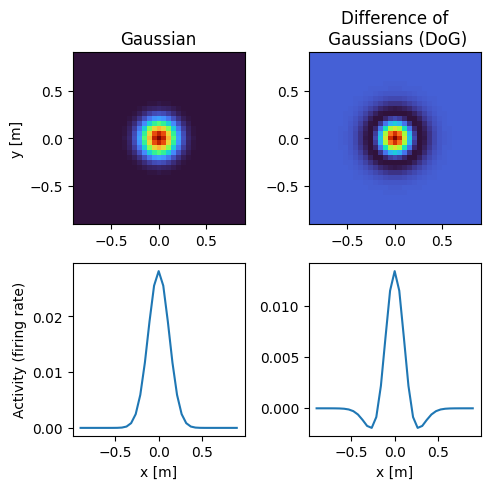

In [6]:
figure(figsize=(5,5))
subplot(2,2,1)
title("Gaussian")
imshow(gau_eg, cmap="turbo", extent=(-box_width/2, box_width/2, -box_height/2, box_height/2))
ylabel("y [m]")
subplot(2,2,2)
title("Difference of\n Gaussians (DoG)")
imshow(dog_eg, cmap="turbo", extent=(-box_width/2, box_width/2, -box_height/2, box_height/2))
subplot(2,2,3)
xp = range(-box_width/2, box_width/2, length=step)
plot(xp, gau_eg[div(step, 2), :])
xlabel("x [m]"); plt.ylabel("Activity (firing rate)")
subplot(2,2,4)
plot(xp, dog_eg[div(step, 2), :])
xlabel("x [m]")
tight_layout()

場所細胞の活動パターンを生み出す．それぞれの場所受容野の中心は一様分布で生み出し，scalingにより境界上にcenterがある場所細胞を抑制しておく．

In [7]:
using Distributions

In [8]:
centers = [rand(Uniform(-box_width/2, box_width/2), Np) rand(Uniform(-box_height/2, box_height/2), Np)];
centers *= 0.9;

In [9]:
X = hcat([DoG(centers[i, :], box_width, box_height, step, sigma, surround_scale)[:] for i in 1:Np]...)';

9個の場所受容野を確認する．

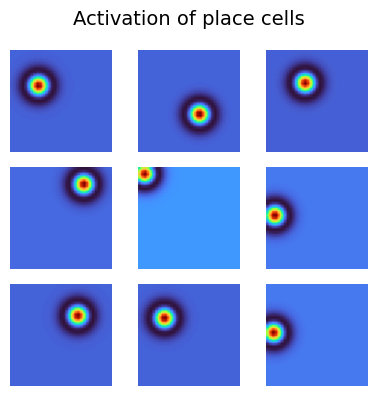

In [10]:
figure(figsize=(4,4))
suptitle("Activation of place cells", fontsize=14)
for i in 1:9
    subplot(3,3,i)
    imshow(reshape(X[i, :], (step,step)), cmap="turbo")
    axis("off")
end
tight_layout()

In [11]:
using FFTW

## 主成分分析 (PCA: principal component analysis)
PCAとNMFの違いは，圧縮表現および変換のための重み行列の符号である．PCAは正負の両者を含むが，**NMFでは圧縮表現と重みの両者が非負**である．この意味は後で触れるとして，比較用にPCAを先に実行する．`sklearn.decomposition`のPCAを用いる．空間方向にflattenしてPCAを実行する．ここではグリッド細胞の数を9個に設定した．

In [12]:
function HebbianPCA(X; n_components=10, η=1e-6, maxiter=200, func=identity, orthogonal=true)
    # X : n x m -> Y : n_components x m
    n = size(X)[1]
    X = (X .- mean(X, dims=2)) ./ std(X, dims=2) # normalization
    Y = nothing
    W = randn(n_components, n) # initialize weight
    W ./= sqrt.(sum(W.^2, dims=2)) # normalization
    for _ in 1:maxiter
        Y = func.(W * X)
        if orthogonal
            W .+= η * (Y * X' - LowerTriangular(Y * Y') * W) # Sanger's rule
        else
            W .+= η * (Y * X' - Diagonal(Y * Y') * W) # Oja's rule
        end
    end
    return Y, W
end

HebbianPCA (generic function with 1 method)

In [24]:
Ng = 9

9

In [25]:
@time Yp, Wp = HebbianPCA(X, n_components=Ng, η=1e-6, orthogonal=true);

  1.424031 seconds (4.25 k allocations: 356.084 MiB, 2.82% gc time)


圧縮表現を取得し，reshapeする．

In [26]:
H_pca = reshape(Yp, (Ng, step, step));

結果を確認する．下段はやや六角形格子のようだが微妙である．

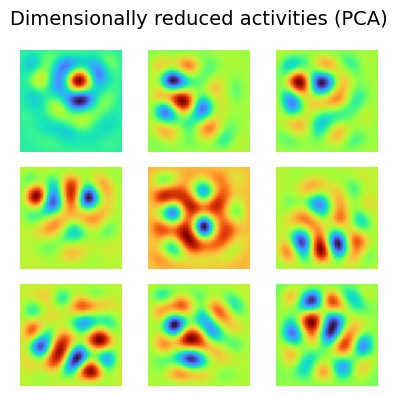

In [27]:
plt.figure(figsize=(4,4))
plt.suptitle("Dimensionally reduced activities (PCA)", fontsize=14)
for i in 1:Ng
    plt.subplot(3,3,i)
    plt.imshow(H_pca[i, :, :], cmap="turbo")
    plt.axis("off")
end
plt.tight_layout()

自己相関マップ(autocorrelation map)を確認する．

In [28]:
function correlate_fft(x, y)
    corr = fftshift(real(ifft(fft(x) .* conj(fft(y)))))
    return corr / maximum(corr)
end;

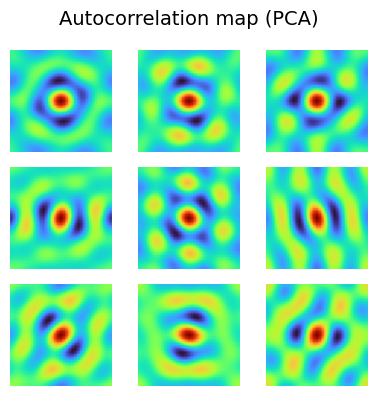

In [29]:
plt.figure(figsize=(4,4))
plt.suptitle("Autocorrelation map (PCA)", fontsize=14)
for i in 1:Ng
    plt.subplot(3,3,i)
    corr = correlate_fft(H_pca[i, :, :], H_pca[i, :, :])
    plt.imshow(corr, cmap="turbo")
    plt.axis("off")
end
plt.tight_layout()

In [30]:
relu(x) = max(x, 0)

relu (generic function with 1 method)

In [42]:
Ys, Ws = HebbianPCA(X; n_components=Ng, η=1e-6, maxiter=1000, func=relu, orthogonal=true);

In [43]:
H_nmf = reshape(Ys, (Ng, step, step));

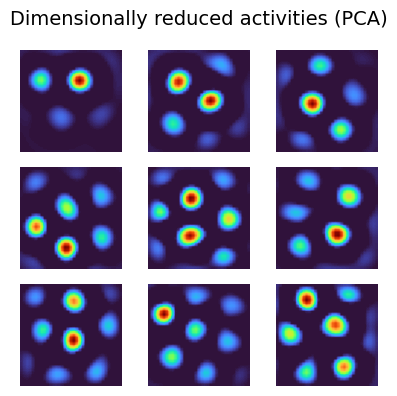

In [44]:
plt.figure(figsize=(4,4))
plt.suptitle("Dimensionally reduced activities (PCA)", fontsize=14)
for i in 1:Ng
    plt.subplot(3,3,i)
    plt.imshow(H_nmf[i, :, :], cmap="turbo")
    plt.axis("off")
end
plt.tight_layout()

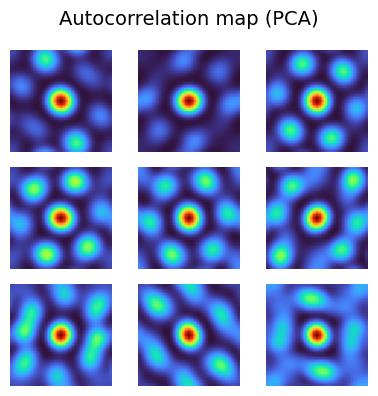

In [38]:
plt.figure(figsize=(4,4))
plt.suptitle("Autocorrelation map (PCA)", fontsize=14)
for i in 1:Ng
    plt.subplot(3,3,i)
    corr = correlate_fft(H_nmf[i, :, :], H_nmf[i, :, :])
    plt.imshow(corr, cmap="turbo")
    plt.axis("off")
end
plt.tight_layout()

上記のようにPCAとNMFでは結果が異なる．大きな違いは圧縮表現が正負(PCA)か非負(NMF)か，という点である．神経活動は非負であるという特徴があり，こうした点からNMFの方が妥当であると言える．じゃあなぜ六角形になるのか，というのは現時点で自分が簡単に説明できないのでもう少しsurveyしてから本には書こうと思う．

ここではNMFの例として用いただけなので，これがGrid cellの妥当なモデルというわけではない．CANやpath integration modelについて触れる．